> # PLEASE REMEMBER TO CHANGE the path of your rgbd-dataset folder to the base path variable!!!

### Some Imports

In [40]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### The list of my object selected

In [41]:
def load_images_from_folder(folder):
    images = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                if '_crop' in filename:
                    img = cv2.imread(os.path.join(subfolder_path, filename))
                    if img is not None:
                        images.append(img)
    return images

### Pick only 10 objects

In [42]:
base_path = "../../../../../Downloads/rgbd-dataset/"
object_folders =  sorted(os.listdir(base_path))
object_folders = object_folders[-10:]  # Get last 10 main folders
# object_folders = random.sample(object_folders, 10) # If you wanna select randomly, you will uncommit this line and remove [-10:] at above line

selected_folders = []
for obj in object_folders:
    obj_path = os.path.join(base_path, obj)
    
    if os.path.isdir(obj_path):
        selected_folders.append(obj_path)

# Load images
images = {}
for folder in selected_folders:
    folder_name = os.path.basename(folder)
    images[folder_name] = load_images_from_folder(folder)

### Your features detected on the objects

In [43]:
# Initialize feature detectors
sift = cv2.SIFT_create()
orb = cv2.ORB_create()
brisk = cv2.BRISK_create()

feature_detectors = {'SIFT': sift, 'ORB': orb, 'BRISK': brisk}

# Get features for all images
features = {}
for detector in feature_detectors:
    features[detector] = {}
    for obj in images:
        features[detector][obj] = []

### The details of your object recognition algorithm

In [44]:
for object in images:
    for img in images[object]:
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        for name, detector in feature_detectors.items():
            keypoints, descriptors = detector.detectAndCompute(gray_image, None)  # Each detector detects and computes
            if descriptors is not None:  # IMPORTANT CASE: Ensure that there are descriptors
                features[name][object].append((keypoints, descriptors))

### Splits Data -> Train: %90 and Test: %10 

In [45]:
def train_test_split(data, test_size=0.1):
    train_data = {}
    test_data = {}
    
    for obj, features in data.items():
        split_idxs = int(len(features) * (1 - test_size))
        train_data[obj] = features[:split_idxs]
        test_data[obj] = features[split_idxs:]

    return train_data, test_data

### Also Splits Features -> Train: %90 and Test: %10 

In [46]:
train_features = {}
for detector in feature_detectors:
    train_features[detector] = {}
    
test_features = {}
for detector in feature_detectors:
    test_features[detector] = {}

for name in feature_detectors.keys():
    train_features[name], test_features[name] = train_test_split(features[name])


### The Classifier

In [47]:
def train_classifier(features):
    descriptors = []
    labels = []

    for label, feature_list in features.items():
        for kp, des in feature_list:
            if des is not None and len(des) > 0:
                descriptors.extend(des)
                labels.extend([label] * len(des))

    if len(descriptors) > 0:
        descriptors = np.array(descriptors)
        labels = np.array(labels)
        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(descriptors, labels)
        return knn
    else:
        return None

In [48]:
classifiers = {}
for name in feature_detectors.keys():
    classifier = train_classifier(train_features[name])
    if classifier is not None:
        classifiers[name] = classifier
    else:
        print(f"Warning: No valid descriptors for {name}")

### Predict Label

In [54]:
def predict_objects(classifier, features, descriptor_name):
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    
    for label, feature_list in features.items():
        print(f"{descriptor_name} > {label}")
        for kp, des in feature_list:          
            if des is not None and len(des) > 0:
                predictions = classifier.predict(des)
                prediction = max(set(predictions), key=predictions.tolist().count)
                all_predictions.append(prediction)
                all_labels.append(label)
                if prediction == label:
                    correct += 1
                total += 1
                # print(f"acc: {correct/total}")  # See accuracy
                
    accuracy = correct / total if total > 0 else 0
    return accuracy, all_labels, all_predictions

### Results & Accuracy

In [56]:
results = {
    'SIFT': {},
    'ORB': {},
    'BRISK': {}
}

for descriptor_name in classifiers.keys():
    accuracy, all_labels, all_predictions = predict_objects(classifiers[descriptor_name], test_features[descriptor_name], descriptor_name)
    results[descriptor_name] = accuracy, all_labels, all_predictions

SIFT > apple
SIFT > crop
SIFT > keyboard
SIFT > pitcher
ORB > apple
ORB > crop
ORB > keyboard
ORB > pitcher
BRISK > apple
BRISK > crop
BRISK > keyboard
BRISK > pitcher


### Plot the final confusion matrix for the 10 objects

In [51]:
def plot_confusion_matrix(labels, predictions, classes):
    cm = confusion_matrix(labels, predictions)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    cm_display.plot()
    plt.figure(figsize=(20, 20))
    plt.show()


Evaluating classifier: SIFT
Accuracies: 1.0


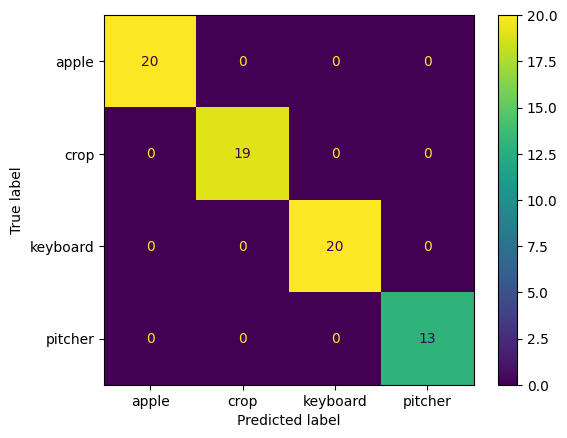

<Figure size 2000x2000 with 0 Axes>


Evaluating classifier: ORB
Accuracies: 0.9387755102040817


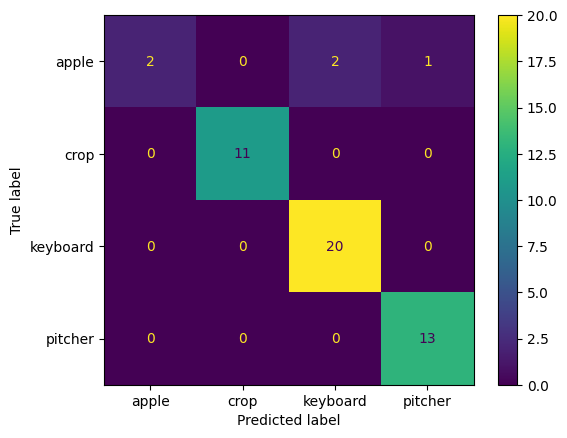

<Figure size 2000x2000 with 0 Axes>


Evaluating classifier: BRISK
Accuracies: 0.9836065573770492


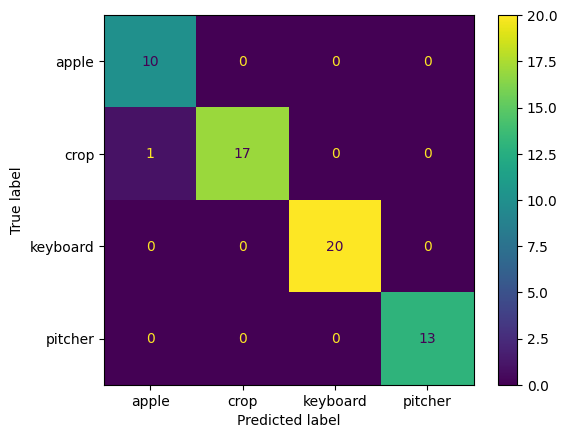

<Figure size 2000x2000 with 0 Axes>

In [52]:
for name in classifiers.keys():
    print(f"\nEvaluating classifier: {name}")
    accuracy, all_labels, all_predictions = results[name]
    
    print("Accuracies:", accuracy)
    plot_confusion_matrix(all_labels, all_predictions, classifiers[name].classes_)